Ever find the code you wrote too spaghetti? Or you want to parallelise some of the steps in the workflow for the sake of better performance and user experience? Or simply retry some of the steps to get different results?

Workflow IMO is particularly relevant in the context of LLM because despite the fact that LLM poses a lot of knowledge and capability of reasoning, without knowing the context of the institutional context and SOP (standard operating procedure), it is likely to produce results that are suboptimal. Workflow (or SOP if you want to think of it this way) is a way to provide a narrow pathway for LLM to follow. It comes with a few benefits:

1. As an operator or engineer who develop LLM-based solutions, a rigid workflow is a way of managing the expectation of the user.
2. With a workflow your SOP is broken down into a series of steps. It's easier for the developer to systematically improving each steps capability, thus improving the overall performance of the workflow.
3. A narrow pathway that reflects the institutional SOP, meaning it's more capable of producing results at scale.
4. It's simpler to manage the human-in-the-loop with workflow as you have clear steps where human operator can intervene.

In this cookbook, we will be looking at 5 levels of workflow orchestration, for the purpose of fun and learning.

Here are the 5 levels:

- Level 1: [Vanilla Async Calls](#level-1-vanilla-async-calls)
- Level 2: [DSL-based DAG with parallel execution](#level-2-async-calls-with-tools)
- Level 3: [DAG with human-in-the-loop](#level-3-dag-with-human-in-the-loop)
- Level 4: [DAG with reasoning](#level-4-dag-with-reasoning)
- Level 5: [Workflow that support loop back](#level-5-workflow-that-support-loop-back)



## Level 1: Vanilla Async Calls

This is the simplest level of workflow orchestration. It's very much chaining async calls up manually via code and asyncio primitives.

Let us create our first workflow.

In [1]:
from opsmate.dino import dino
from pydantic import BaseModel
import asyncio

class HomeTownInfo(BaseModel):
  person_name: str
  home_town: str

@dino(
  model="gpt-4o-mini",
  response_model=HomeTownInfo,
)
async def home_town(person_name: str) -> str:
  """
  You are given a person's name, return the home town of the person.
  """
  return person_name


@dino(
  model="gpt-4o-mini",
  response_model=str,
)
async def distance(h1: HomeTownInfo, h2: HomeTownInfo) -> str:
  """
  You are given two places, return the distance between the two places in km.
  """
  return f"The distance between {h1.home_town} and {h2.home_town}"


results = await asyncio.gather(*[home_town("Tony Blair"), home_town("Elon Musk")])

print(results)
print(await distance(results[0], results[1]))


[HomeTownInfo(person_name='Tony Blair', home_town='Edinburgh'), HomeTownInfo(person_name='Elon Musk', home_town='Pretoria, South Africa')]
The distance between Edinburgh, Scotland, and Pretoria, South Africa, is approximately 8,600 kilometers (5,343 miles).


In this relatively simple example, the code is reasonably manageable. That being said there are a few issues:

1. We need to topologically sort the procedures, which is not always easy.
2. We have to manually manage the concurrency of the steps.

This is where we can use the DSL-based DAG to help us.

## Level 2: DSL-based DAG with parallel execution

We will use the Workflow DSL from Opsmate to define and execute the workflow.

In [2]:
from opsmate.workflow.workflow import (
    step,
    step_factory,
    StatelessWorkflowExecutor,
    WorkflowContext,
)
from pydantic import BaseModel
from opsmate.dino import dino


class HomeTownInfo(BaseModel):
    person_name: str
    home_town: str


def home_town(person_name: str):
    @step_factory
    @step
    @dino(
        model="gpt-4o-mini",
        response_model=HomeTownInfo,
    )
    async def _home_town(ctx) -> str:
        """
        You are given a person's name, return the home town of the person.
        """
        return ctx.metadata["person_name"]

    return _home_town(metadata={"person_name": person_name})


@step
@dino(
    model="gpt-4o-mini",
    response_model=str,
)
async def distance(ctx) -> str:
    """
    You are given two places, return the distance between the two places in km.
    """
    return f"The distance between {ctx.step_results[0].home_town} and {ctx.step_results[1].home_town}"


workflow = (home_town("Tony Blair") | home_town("Elon Musk")) >> distance

executor = StatelessWorkflowExecutor(workflow)

ctx = WorkflowContext()
await executor.run(ctx)

print(ctx.results['distance'])

2025-01-15 20:03:36 [info     ] rshift                         left=Step(WorkflowType.PARALLEL-725095f7) right=Step(distance-05e141bd)
2025-01-15 20:03:36 [info     ] Running round                  round=1 steps_left=5
2025-01-15 20:03:36 [info     ] Running step                   prev_size=0 step=Step(_home_town-7b526f4a) step_op=<WorkflowType.NONE: 'none'>
2025-01-15 20:03:36 [info     ] Running step                   prev_size=0 step=Step(_home_town-b2cc3e1f) step_op=<WorkflowType.NONE: 'none'>
2025-01-15 20:03:37 [info     ] Running round                  round=2 steps_left=3
2025-01-15 20:03:37 [info     ] Running step                   prev_size=0 step=Step(WorkflowType.PARALLEL-725095f7) step_op=<WorkflowType.PARALLEL: 'parallel'>
2025-01-15 20:03:37 [info     ] Running round                  round=3 steps_left=2
2025-01-15 20:03:37 [info     ] Running step                   prev_size=0 step=Step(WorkflowType.SEQUENTIAL-5c6494e1) step_op=<WorkflowType.SEQUENTIAL: 'sequential'>
2

The code itself is slightly more wordly, however it allows:

1. Parallel execution of steps (as you can see in the logs, workflow steps can be batched up in a single "round").
2. Provide traceability of the steps
3. It's easier to visualise the workflow, which is typically required as part of the LLM application requirement.

In fact we can visualise it with the `draw_dot` function from the workflow module as shown below:

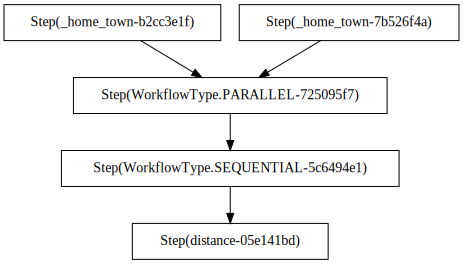

In [4]:
from opsmate.workflow.workflow import draw_dot

dot = draw_dot(workflow, rankdir="TB")
dot


## Level 3: DAG with human-in-the-loop

The previous stateless workflow is working as intended, however there are a few issues:

1. There is no way to correct the workflow output if the output is not desirable. This is because:
    * AI, just like human, sometimes makes mistakes, when it makes mistakes we either have to ask it to re-run, or take direct control to correct the output.
    * Sometimes the question presented to the LLM is simply ill-defined or unclear, thus need constant refinement.
2. The state of the workflow is not persisted, meaning if the workflow is interrupted there is no way to recover.

Luckily both issues can be solved via persisting the workflow state.
In this level we will try to add a human-in-the-loop to the workflow, we will demonstate this via correcting the output of Tony Blair's home town.


In [5]:
from opsmate.workflow.workflow import WorkflowExecutor, build_workflow
from opsmate.workflow.models import SQLModel
from sqlmodel import create_engine, Session

engine = create_engine("sqlite:///:memory:")
SQLModel.metadata.create_all(engine)


In [5]:
# let's re-use the workflow from the previous level
blueprint = (home_town("Tony Blair") | home_town("Elon Musk")) >> distance

session = Session(engine)

workflow = build_workflow("workflow", "Workflow", blueprint, session)

executor = WorkflowExecutor(workflow, session)
ctx = WorkflowContext()
await executor.run(ctx)

print(workflow.find_step("distance", session).result)

# find Elon Musk's result
elon_step = workflow.find_step("_home_town", session, metadata={"person_name": "Elon Musk"})
elon_step_result = elon_step.result
elon_step_result.home_town = "New York"
elon_step.result = elon_step_result
session.add(elon_step)
session.commit()

await executor.mark_rerun(elon_step, self_rerun=False)
await executor.run(ctx)

print(workflow.find_step("distance", session).result)


2025-01-15 18:20:34 [info     ] rshift                         left=Step(WorkflowType.PARALLEL-6627e483) right=Step(distance-e45c74ff)
2025-01-15 18:20:34 [info     ] Running round                  round=1
2025-01-15 18:20:34 [info     ] Running step                   step_id=1 step_name=_home_town
2025-01-15 18:20:34 [info     ] Running step                   step_id=1 step_name=_home_town step_type=<WorkflowType.NONE: 'none'>
2025-01-15 18:20:34 [info     ] Running step                   step_fn=home_town.<locals>._home_town step_id=1 step_name=_home_town
2025-01-15 18:20:34 [info     ] Running step                   step_id=2 step_name=_home_town
2025-01-15 18:20:34 [info     ] Running step                   step_id=2 step_name=_home_town step_type=<WorkflowType.NONE: 'none'>
2025-01-15 18:20:34 [info     ] Running step                   step_fn=home_town.<locals>._home_town step_id=2 step_name=_home_town
2025-01-15 18:20:34 [info     ] Running round                  round=2
2025-01

In the example above. Instead of running a stateless workflow, we ran a workflow backed by a sqlite database so that it supports durable execution.

We run the workflow, and it produces

```
The distance between Edinburgh, Scotland, and Pretoria, South Africa is approximately 8,300 kilometers.
```

Which is identical to the output from the stateless workflow execution.

To demonstrate the human-in-the-loop, we corrected the output of Elon Musk's home town to "New York".

We then re-run the workflow, and it produced

```
The distance between Edinburgh, Scotland, and New York, USA is approximately 5,900 kilometers.
```

The steps of the second persisted workflow execution is also shorter, which is expected because only the descendant steps of the "Elon Musk" step is re-run.

## Level 4: DAG with reasoning

Imagining in the real world as a platform engineer or SRE, you are presented with a problem, and ask it to solve it following the SOP. Despite the steps are well defined and broken down, chances are certain steps require quite a bit thinking and reasoning to solve.

Same is applicable to LLM. There are tasks where it just cannot "one-shot" solve it, and requires thinking and trial and error.

In this level, we will be looking at how to add reasoning to the workflow. Unlike the workflow examples above where the scope of each step is narrowly defined, in this level the scope of each step is broader, and requires reasoning to solve.


In [11]:
from opsmate.tools import FilesFind
from opsmate.dino.react import react
from opsmate.dino.tools import dtool
from opsmate.workflow.workflow import step
from typing import Annotated
from pydantic import BaseModel, Field
import asyncio
import structlog

logger = structlog.get_logger()


@dtool
async def count_loc(filepath: Annotated[str, "The path of the exact file"]) -> str:
    """
    Count the lines of code in the given file.
    """

    output = await asyncio.create_subprocess_shell(
        f"wc -l {filepath}",
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.STDOUT,
    )
    stdout, _ = await output.communicate()
    return stdout.decode().strip()


@dtool
async def add(numbers: Annotated[list[int], "The numbers to add"]) -> str:
    """
    Add the given numbers.
    """
    return str(sum(numbers))


class Step(BaseModel):
    description: str = Field(description="The description of the step")

class Plan(BaseModel):
    goal: str = Field(description="The goal of the task")
    steps: list[Step] = Field(description="Steps to solve the problem the steps must be in sequential order")

@step
@dino(
    model="gpt-4o",
    response_model=Plan,
)
async def planning(ctx: WorkflowContext):
    """
    You are a world-class planning algorithm.
    You are given a problem, try to break it down into a series of steps in sequential order.
    Think step by step to have a good understanding of the problem
    """
    return ctx.input["problem"]

@react(
    model="gpt-4o",
    tools=[FilesFind, count_loc, add],
    iterable=True,
)
async def _execute_plan(plan: Plan):
    """
    You are given a plan, execute the plan by using the tools provided.
    Please do it step by step.
    """
    return f"""
<plan>
## Goal
{plan.goal}

## Steps
{"---\n".join([step.description for step in plan.steps])}
</plan>
"""

@step
async def execute_plan(ctx: WorkflowContext):
    plan = ctx.step_results
    async for result in await _execute_plan(plan):
        _result = result
        logger.info("thought process", result=result)

    return _result

blueprint = planning >> execute_plan

workflow = build_workflow("plan-then-execute", "Plan then execute", blueprint, session)
executor = WorkflowExecutor(workflow, session)

ctx = WorkflowContext(input={"problem": "Find all the jypyter notebook files in the current directory and count the number of lines each file, add the result and print it"})
await executor.run(ctx)

print(ctx.results['execute_plan'])


2025-01-15 18:32:55 [info     ] rshift                         left=Step(planning-9db1b9b7) right=Step(execute_plan-bf3f0b37)
2025-01-15 18:32:55 [info     ] Running round                  round=1
2025-01-15 18:32:55 [info     ] Running step                   step_id=18 step_name=planning
2025-01-15 18:32:55 [info     ] Running step                   step_id=18 step_name=planning step_type=<WorkflowType.NONE: 'none'>
2025-01-15 18:32:55 [info     ] Running step                   step_fn=planning step_id=18 step_name=planning
2025-01-15 18:32:58 [info     ] Running round                  round=2
2025-01-15 18:32:58 [info     ] Running step                   step_id=19 step_name=
2025-01-15 18:32:58 [info     ] Running step                   step_id=19 step_name= step_type=<WorkflowType.SEQUENTIAL: 'sequential'>
2025-01-15 18:32:58 [info     ] Running round                  round=3
2025-01-15 18:32:58 [info     ] Running step                   step_id=20 step_name=execute_plan
2025-01-15

In the example above, we simply defined a very high level and simple workflow:

```
planning >> execute_plan
```

In the `planning` step, we are asking the LLM to break down the problem into a series of steps in sequential order.

In the `execute_plan` step, we are asking the LLM to execute the plan by using the tools provided. Despite the plan presented to the LLM is step by step, the series of execution still leave a lot of room for the LLM to interpret. Here we use the [ReAct](https://arxiv.org/abs/2210.03629) to mimic the conventional thinking-acting-observing problem solving loop.

One of the benefit of this approach is that again if we are not satisfied with the plan (either due to the flaws in the plan or question being ill-defined), we can directly refine the plan to influnce LLM's execution.

## Level 5: Workflow that support loop back

The idea is that upon the completion of a step, or during the execution of a step, the workflow itself has a self-reflexion to determine whether it is on the right track. If it is not, it will backtrack to the previous checkpoint and re-run rest of the steps.

_Coming soon_